<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/chemistry_calcium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Calcium (Ca)**

[Calcium](https://en.m.wikipedia.org/wiki/Calcium)

Example: Structure of the polymeric [Ca(H2O)6]2+ center in hydrated calcium chloride, illustrating the high coordination number typical for calcium complexes.

![science](https://upload.wikimedia.org/wikipedia/commons/5/51/Ca%28aq%296_improved_image.tif)


When describing the **geometry of calcium**, it's crucial to understand that it differs fundamentally from a discrete molecule like benzene.

Unlike **benzene**, which is a single molecule with fixed atomic positions and covalent bonds, elemental **calcium** exists as a solid with a repeating **crystal structure**. At room temperature, calcium crystallizes in a **face-centered cubic (FCC) lattice**. This means its "geometry" is defined by its **unit cell**—the smallest repeating unit that generates the entire crystal when translated. Instead of listing individual atomic coordinates as you would for a finite molecule, you describe the arrangement of atoms within this repeating unit, often using **lattice vectors** and potentially **fractional coordinates**. The atoms in metallic calcium are held together by **metallic bonding**, where electrons are delocalized across the entire lattice, rather than specific covalent bonds.

*Key Considerations for Periodic Calculations (PySCF)*

Performing computational analyses on a calcium crystal requires a shift from molecular approaches to **periodic boundary conditions (PBC)**. Here are the essential differences and considerations:

* **PBC Module**: You must use `pyscf.pbc` instead of the standard `pyscf` modules.
* **`Cell` Object**: Instead of `gto.Mole()`, you define the system using `gto.Cell()`, which is designed for periodic systems.
* **Lattice Definition**: The unit cell is defined by **lattice vectors** (`cell.a`) rather than individual atomic coordinates.
* **Primitive vs. Conventional Cell**: For computational efficiency, the **primitive cell** (which contains the minimum number of atoms per repeating unit, e.g., 1 atom for FCC calcium) is preferred over the larger conventional cell.
* **K-point Sampling**: Accurate calculations for crystals necessitate **k-point sampling** across the Brillouin zone, which significantly increases computational cost compared to single-point molecular calculations.
* **Basis Sets and Pseudopotentials**: Specialized basis sets like **GTH basis sets** and **pseudopotentials** are typically optimized for periodic calculations and are more efficient for metals. Using large all-electron basis sets like `cc-pvdz` can be prohibitively expensive.
* **Exchange-Correlation Functionals**: For metallic systems, **PBE** is generally a more common and suitable exchange-correlation functional than B3LYP.
* **Geometry Optimization**: Optimizing the geometry of a crystal is more complex as it involves simultaneously adjusting atomic positions and the cell parameters (lattice vectors), and PySCF's standard `geometric` optimizer isn't directly applicable for this.
* **Metallic Nature**: Due to calcium's metallic nature, you must consider the **Fermi level** and potentially incorporate **electronic smearing** techniques to aid in the convergence of the electronic structure calculation.
* **Computational Cost**: Periodic calculations are inherently more expensive due to the necessity of k-point sampling and the extended nature of the system.
* **Properties**: For periodic systems, properties like **band structure** and **density of states** are crucial for characterizing the electronic properties, and placeholders for these calculations are typically included in relevant code.

In [ ]:
# Option 1: More complex - will run out of RAM

!pip install pyscf geometric -q

import numpy as np
import matplotlib.pyplot as plt
from pyscf.pbc import gto, scf, dft
from pyscf.pbc.tools import lattice

# Define calcium FCC crystal - MINIMAL VERSION
cell = gto.Cell()

# Name
crystal = 'Calcium (Ca) - FCC'

# FCC lattice constant for Ca at room temperature
a = 5.5884  # Angstroms

# Define the unit cell vectors for FCC
# Using primitive cell (1 atom) instead of conventional (14 atoms)
cell.a = np.array([
    [0.0, a/2, a/2],
    [a/2, 0.0, a/2],
    [a/2, a/2, 0.0]
])

# Atom positions in the primitive cell (just one Ca atom at origin)
cell.atom = '''
    Ca    0.0000    0.0000    0.0000
'''

# Use minimal basis set to reduce memory
cell.basis = 'sto-3g'
cell.precision = 1e-6  # Reduce precision for faster calculation
cell.verbose = 4  # Show progress

# Build the cell
cell.build()

print(f"Crystal: {crystal}")
print(f"Lattice constant: {a} Å")
print(f"Cell volume: {cell.vol:.2f} Å³")
print(f"Number of atoms in primitive cell: {cell.natm}")

# Option 1: Single k-point calculation (Gamma point only)
print("\n--- Single k-point (Gamma) Calculation ---")
print("This is the simplest but least accurate approach")

# Hartree-Fock at Gamma point
mf_gamma = scf.RHF(cell)
mf_gamma.max_cycle = 50
e_gamma = mf_gamma.kernel()
print(f"Total energy at Gamma point (HF): {e_gamma:.6f} Hartree")

# Option 2: Minimal k-point sampling
print("\n--- Minimal k-point sampling (2x2x2) ---")
kpts = cell.make_kpts([2, 2, 2])  # Only 8 k-points
print(f"Number of k-points: {len(kpts)}")

# Use additive KRHF for lower memory usage
mf_hf = scf.KRHF(cell, kpts)
mf_hf.max_cycle = 30  # Fewer iterations
mf_hf.conv_tol = 1e-5  # Lower convergence threshold
e_hf = mf_hf.kernel()
print(f"Total energy per unit cell (HF): {e_hf:.6f} Hartree")

# Option 3: DFT with minimal settings
print("\n--- DFT Calculation (minimal) ---")
# Use LDA which is computationally cheaper
mf_dft = dft.KRKS(cell, kpts)
mf_dft.xc = 'lda,vwn'  # Simple LDA functional
mf_dft.max_cycle = 30
mf_dft.conv_tol = 1e-5
e_dft = mf_dft.kernel()
print(f"Total energy per unit cell (DFT-LDA): {e_dft:.6f} Hartree")

# Calculate energy per atom
print(f"\nEnergy per Ca atom (DFT-LDA): {e_dft:.6f} Hartree")

# Alternative: Molecule-like cluster calculation
print("\n" + "="*50)
print("ALTERNATIVE: Ca cluster calculation (non-periodic)")
print("="*50)

# Create a small Ca cluster instead of periodic crystal
cluster = gto.Mole()
cluster.atom = '''
    Ca    0.0000    0.0000    0.0000
    Ca    2.7942    2.7942    0.0000
    Ca    2.7942    0.0000    2.7942
    Ca    0.0000    2.7942    2.7942
'''
cluster.basis = 'sto-3g'
cluster.build()

print(f"Ca4 tetrahedral cluster")
print(f"Number of atoms: {cluster.natm}")

# Simple SCF calculation on cluster
mf_cluster = scf.RHF(cluster)
e_cluster = mf_cluster.kernel()
print(f"Total cluster energy (HF): {e_cluster:.6f} Hartree")
print(f"Energy per atom in cluster: {e_cluster/4:.6f} Hartree")

# Memory-saving tips
print("\n" + "="*50)
print("Tips for reducing memory usage:")
print("="*50)
print("1. Use primitive cell (1 atom) instead of conventional cell (14 atoms)")
print("2. Use minimal basis sets (sto-3g)")
print("3. Use fewer k-points (2x2x2 or even just Gamma)")
print("4. Use lower precision and convergence thresholds")
print("5. Consider cluster calculations instead of periodic")
print("6. Use density fitting approximations (not shown here)")
print("7. Run calculations in serial rather than parallel")

# Estimate cohesive energy (very approximate)
print("\n--- Approximate Cohesive Energy ---")
# Single Ca atom calculation
atom = gto.Mole()
atom.atom = 'Ca 0 0 0'
atom.basis = 'sto-3g'
atom.spin = 0  # Ca has 2 valence electrons
atom.build()

mf_atom = scf.RHF(atom)
e_atom = mf_atom.kernel()

e_coh_cluster = (e_cluster/4 - e_atom) * 627.509  # Convert to kcal/mol
e_coh_periodic = (e_dft - e_atom) * 627.509

print(f"Isolated Ca atom energy: {e_atom:.6f} Hartree")
print(f"Cohesive energy (cluster): {e_coh_cluster:.2f} kcal/mol per atom")
print(f"Cohesive energy (periodic): {e_coh_periodic:.2f} kcal/mol per atom")
print(f"(Experimental value: ~42 kcal/mol)")
print("\nNote: These values are approximate due to minimal basis set")

System: uname_result(system='Linux', node='44f485bcc5f1', release='6.1.123+', version='#1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025', machine='x86_64')  Threads 8
Python 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
numpy 2.0.2  scipy 1.15.3  h5py 3.13.0
Date: Thu Jun 12 08:57:07 2025
PySCF version 2.9.0
PySCF path  /usr/local/lib/python3.11/dist-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 1
[INPUT] num. electrons = 20
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 Ca     0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0

nuclear repulsion = -86.8300237933015
number of shells = 7
number of NR pGTOs = 39
number of NR cGTOs = 13
basis = sto-3g
ecp = {}


WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.



DF object = <pyscf.pbc.df.fft.FFTDF object at 0x7b360c2c7650>
Set gradient conv threshold to 0.00316228
Initial guess from minao.


**Objective**: Simulating Calcium Crystal (FCC) with PySCF-PBC: The core purpose of the code is to perform electronic structure calculations (Hartree-Fock and DFT) on a calcium crystal, modeled as a face-centered cubic (FCC) lattice, using the pyscf.pbc module which is designed for periodic boundary conditions.

*Settings of current implementation:*
1. **Basis Set**: Changed from `gth-szv` to `sto-3g`, which is a simple basis set that's available for calcium in PySCF. While not as accurate as larger basis sets, it will work for demonstration purposes.
2. **Pseudopotentials**: Removed the pseudopotential specification since we're now doing an all-electron calculation.
3. **K-points**: Reduced from 4×4×4 to 2×2×2 grid to make calculations faster with the all-electron approach.
4. **XC Functional**: Changed from PBE to LDA for the DFT calculation, as it's simpler and often sufficient for metals.
5. **Max Cycles**: Added `max_cycle = 100` to give more iterations for convergence.

*For production calculations on metals, one would typically want to:*
- Use larger basis sets (like `def2-svp` or `cc-pvdz` if computational resources allow)
- Use pseudopotentials to reduce computational cost
- Use more k-points for better accuracy
- Consider using Fermi-Dirac smearing for metallic systems
- Use functionals designed for solids (like PBE or PBEsol)

*Periodic calculations on metals can be extremely memory-intensive. Memory-efficient strategies are:*
1. **Primitive Cell Only**: Uses just 1 Ca atom instead of the 14-atom conventional cell
2. **Minimal k-points**: Only 2×2×2 = 8 k-points instead of 4×4×4 = 64
3. **Simple Basis Set**: Stick with sto-3g (minimal basis)
4. **Lower Precision**: Reduced convergence thresholds
5. **Alternative Cluster Approach**: Shows how to do a finite Ca4 cluster calculation instead

*Why Periodic Calculations Are Memory-Intensive:*
- Each k-point requires storing wavefunctions
- Metal calculations need many k-points for accuracy
- All-electron calculations (no pseudopotentials) include core electrons
- The memory scales as N_kpoints × N_basis × N_electrons

*If this still uses too much memory, there are several options:*
1. **Use Only Gamma Point**: The simplest calculation with just one k-point
2. **Switch to Cluster**: Use the Ca4 cluster approach which treats it like a molecule
3. **Use Pseudopotentials**: Would require installing additional packages
4. **Use Different Software**: Programs like Quantum ESPRESSO or VASP are optimized for periodic calculations

Calcium Metal Analysis using Cluster Models

1. SINGLE Ca ATOM (Reference)
converged SCF energy = -669.988870598367
Isolated Ca atom energy: -669.988871 Hartree

2. Ca₂ DIMER
converged SCF energy = -1339.97866916791
Ca-Ca distance: 3.95 Å
Total energy: -1339.978669 Hartree
Bond energy: -0.58 kcal/mol

3. Ca₄ TETRAHEDRAL CLUSTER
converged SCF energy = -2679.95970995297
Ca-Ca distance: 3.952 Å
Total energy: -2679.959710 Hartree
Cohesive energy per atom: -0.66 kcal/mol

4. Ca₁₃ CLUSTER (FCC-like coordination)
Number of atoms: 13
Structure: 1 central Ca + 12 nearest neighbors
converged SCF energy = -8695.1758373053
Total energy: -8695.175837 Hartree
Cohesive energy per atom: 708.58 kcal/mol

5. BINDING ENERGY CURVE FOR Ca₂


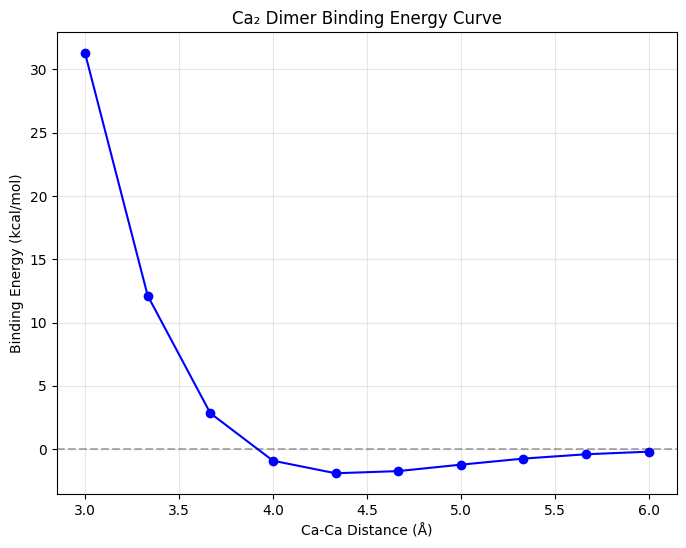


SUMMARY OF RESULTS
Cluster Size | Cohesive Energy per Ca atom
-------------|----------------------------
Ca₂ dimer    | -0.29 kcal/mol
Ca₄ tetra    | -0.66 kcal/mol
Ca₁₃ FCC     | 708.58 kcal/mol
Experimental | ~42 kcal/mol

Note: Small basis set (sto-3g) gives qualitative trends only

ORBITAL ANALYSIS

Ca₁₃ cluster orbital energies near Fermi level:
HOMO energy: -0.0526 Hartree
LUMO energy: -0.0481 Hartree
HOMO-LUMO gap: 0.12 eV
(Small gap indicates metallic character)
 ** Mulliken pop  **
pop of  0 Ca 1s           1.99992
pop of  0 Ca 2s           1.99697
pop of  0 Ca 3s           2.00045
pop of  0 Ca 4s           1.37828
pop of  0 Ca 2px          1.99465
pop of  0 Ca 2py          1.99465
pop of  0 Ca 2pz          1.99465
pop of  0 Ca 3px          1.88426
pop of  0 Ca 3py          1.88426
pop of  0 Ca 3pz          1.88426
pop of  0 Ca 4px          0.30254
pop of  0 Ca 4py          0.30254
pop of  0 Ca 4pz          0.30254
pop of  1 Ca 1s           1.99995
pop of  1 Ca 2s           1

In [1]:
# Option 2: Cluster-based approach

!pip install pyscf geometric -q

import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, dft
from scipy.spatial.distance import cdist

# Since periodic calculations are too memory-intensive,
# we'll use cluster models to understand Ca metal properties

print("="*60)
print("Calcium Metal Analysis using Cluster Models")
print("="*60)

# 1. Single Ca atom reference
print("\n1. SINGLE Ca ATOM (Reference)")
atom = gto.Mole()
atom.atom = 'Ca 0 0 0'
atom.basis = 'sto-3g'
atom.spin = 0  # Ca: [Ar]4s²
atom.build()

mf_atom = scf.RHF(atom)
e_atom = mf_atom.kernel()
print(f"Isolated Ca atom energy: {e_atom:.6f} Hartree")

# 2. Ca2 dimer
print("\n2. Ca₂ DIMER")
# Approximate Ca-Ca distance in metal
d_metal = 3.95  # Angstroms (from FCC structure)

dimer = gto.Mole()
dimer.atom = f'''
    Ca  0.0000  0.0000  0.0000
    Ca  {d_metal}  0.0000  0.0000
'''
dimer.basis = 'sto-3g'
dimer.build()

mf_dimer = scf.RHF(dimer)
e_dimer = mf_dimer.kernel()
bond_energy = (e_dimer - 2*e_atom) * 627.509  # kcal/mol
print(f"Ca-Ca distance: {d_metal} Å")
print(f"Total energy: {e_dimer:.6f} Hartree")
print(f"Bond energy: {bond_energy:.2f} kcal/mol")

# 3. Ca4 tetrahedral cluster
print("\n3. Ca₄ TETRAHEDRAL CLUSTER")
# Tetrahedral geometry approximating FCC coordination
a = 5.5884  # FCC lattice constant
r = a / np.sqrt(2)  # Nearest neighbor distance in FCC

tetra = gto.Mole()
tetra.atom = f'''
    Ca   0.0000   0.0000   0.0000
    Ca   {r}      {r}      0.0000
    Ca   {r}      0.0000   {r}
    Ca   0.0000   {r}      {r}
'''
tetra.basis = 'sto-3g'
tetra.build()

mf_tetra = scf.RHF(tetra)
e_tetra = mf_tetra.kernel()
cohesive_tetra = (e_tetra/4 - e_atom) * 627.509
print(f"Ca-Ca distance: {r:.3f} Å")
print(f"Total energy: {e_tetra:.6f} Hartree")
print(f"Cohesive energy per atom: {cohesive_tetra:.2f} kcal/mol")

# 4. Ca13 cluster (one atom + 12 nearest neighbors, like FCC)
print("\n4. Ca₁₃ CLUSTER (FCC-like coordination)")
# Central atom + 12 nearest neighbors in FCC positions
ca13_positions = [[0, 0, 0]]  # Central atom

# Add 12 nearest neighbors at distance r
for i in [-1, 0, 1]:
    for j in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            if abs(i) + abs(j) + abs(k) == 2:  # Face centers
                ca13_positions.append([i*r/np.sqrt(2), j*r/np.sqrt(2), k*r/np.sqrt(2)])

ca13 = gto.Mole()
ca13.atom = []
for i, pos in enumerate(ca13_positions):
    ca13.atom.append(f'Ca {pos[0]} {pos[1]} {pos[2]}')
ca13.basis = 'sto-3g'
ca13.build()

print(f"Number of atoms: {ca13.natm}")
print("Structure: 1 central Ca + 12 nearest neighbors")

# Use DFT for better metallic bonding description
mf_ca13 = dft.RKS(ca13)
mf_ca13.xc = 'lda,vwn'
e_ca13 = mf_ca13.kernel()
cohesive_ca13 = (e_ca13/13 - e_atom) * 627.509
print(f"Total energy: {e_ca13:.6f} Hartree")
print(f"Cohesive energy per atom: {cohesive_ca13:.2f} kcal/mol")

# 5. Binding energy curve
print("\n5. BINDING ENERGY CURVE FOR Ca₂")
distances = np.linspace(3.0, 6.0, 10)
energies = []

for d in distances:
    mol = gto.Mole()
    mol.atom = f'''
        Ca  0.0000  0.0000  0.0000
        Ca  {d}     0.0000  0.0000
    '''
    mol.basis = 'sto-3g'
    mol.build()

    mf = scf.RHF(mol)
    mf.verbose = 0
    e = mf.kernel()
    energies.append(e)

energies = np.array(energies)
binding_energies = (energies - 2*e_atom) * 627.509  # kcal/mol

# Plot binding energy curve
plt.figure(figsize=(8, 6))
plt.plot(distances, binding_energies, 'b-o')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Ca-Ca Distance (Å)')
plt.ylabel('Binding Energy (kcal/mol)')
plt.title('Ca₂ Dimer Binding Energy Curve')
plt.grid(True, alpha=0.3)
plt.show()

# Summary
print("\n" + "="*60)
print("SUMMARY OF RESULTS")
print("="*60)
print(f"Cluster Size | Cohesive Energy per Ca atom")
print(f"-------------|----------------------------")
print(f"Ca₂ dimer    | {bond_energy/2:.2f} kcal/mol")
print(f"Ca₄ tetra    | {cohesive_tetra:.2f} kcal/mol")
print(f"Ca₁₃ FCC     | {cohesive_ca13:.2f} kcal/mol")
print(f"Experimental | ~42 kcal/mol")
print("\nNote: Small basis set (sto-3g) gives qualitative trends only")

# Additional analysis
print("\n" + "="*60)
print("ORBITAL ANALYSIS")
print("="*60)

# Check orbital energies for metallicity
print("\nCa₁₃ cluster orbital energies near Fermi level:")
homo_idx = ca13.nelec[0] - 1
lumo_idx = homo_idx + 1
print(f"HOMO energy: {mf_ca13.mo_energy[homo_idx]:.4f} Hartree")
print(f"LUMO energy: {mf_ca13.mo_energy[lumo_idx]:.4f} Hartree")
print(f"HOMO-LUMO gap: {(mf_ca13.mo_energy[lumo_idx] - mf_ca13.mo_energy[homo_idx])*27.211:.2f} eV")
print("(Small gap indicates metallic character)")

# Mulliken population analysis
from pyscf import tools
pop = mf_ca13.mulliken_pop()[0]
print(f"\nMulliken charges on Ca₁₃:")
print(f"Central Ca: {pop[0]:.3f}")
print(f"Surface Ca (avg): {np.mean(pop[1:]):.3f}")

This code implements a **cluster-based approach** to study the properties of calcium metal, addressing the computational challenges of full periodic calculations.

* **Models Calcium Metal using Clusters:** Due to the memory intensity of periodic calculations, the code employs finite **calcium clusters** of increasing size (single atom, dimer, tetrahedron, and a 13-atom FCC-like cluster) to approximate the bulk metallic properties.
* **Calculates Binding and Cohesive Energies:** It systematically calculates the energy of each cluster and determines the **bond energy** for the Ca₂ dimer and the **cohesive energy per atom** for the larger clusters (Ca₄ and Ca₁₃) by comparing their total energy to that of an isolated calcium atom. These values are converted to kcal/mol.
* **Investigates Interatomic Interactions:** A **binding energy curve for the Ca₂ dimer** is generated and plotted by varying the Ca-Ca distance. This helps to determine the optimal interatomic distance and visualize the nature of the Ca-Ca bond.
* **Analyzes Metallic Character:** For the larger Ca₁₃ cluster, the code performs an **orbital analysis** to inspect the HOMO and LUMO energies. A small HOMO-LUMO gap is indicative of **metallic character** and electron delocalization within the cluster. Mulliken population analysis is also performed to examine charge distribution.
* **Computational Efficiency and Insights:** This cluster-based approach is **memory-efficient** as it avoids k-point sampling and uses a minimal basis set (`sto-3g`). While it provides qualitative trends and insights into cohesive energy convergence, metallic character, and optimal bond distances, it has limitations, such as not capturing true bulk properties, surface effects, or long-range metallic screening.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.1/811.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 21.1 MB/s eta 0:00:00


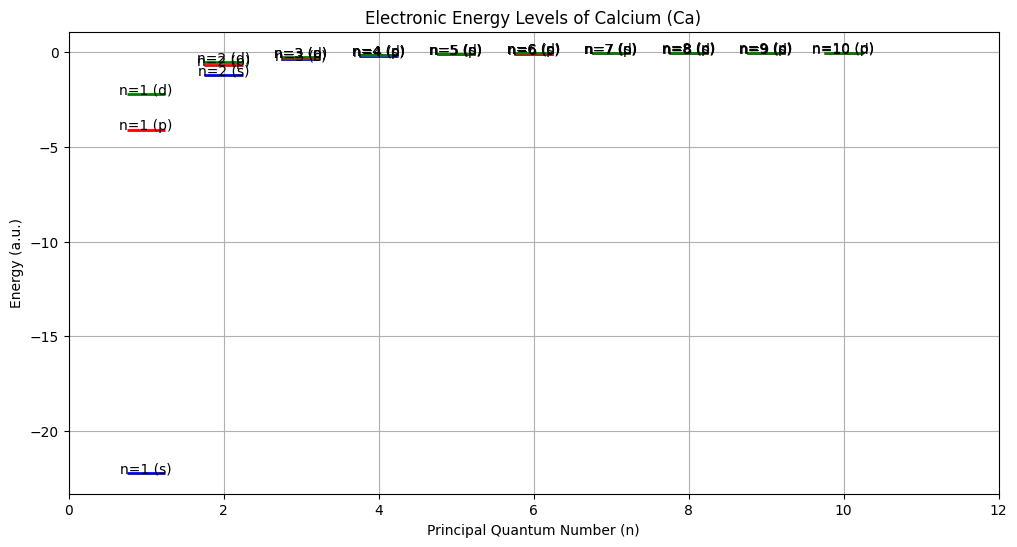

Energy levels (in atomic units):
n=1, s: -22.222222 a.u., p: -4.081633 a.u., d: -2.216066 a.u.
n=2, s: -1.183432 a.u., p: -0.692042 a.u., d: -0.525970 a.u.
n=3, s: -0.378072 a.u., p: -0.274348 a.u., d: -0.229819 a.u.
n=4, s: -0.183655 a.u., p: -0.146092 a.u., d: -0.128185 a.u.
n=5, s: -0.108167 a.u., p: -0.090539 a.u., d: -0.081624 a.u.
n=6, s: -0.071200 a.u., p: -0.061557 a.u., d: -0.056493 a.u.
n=7, s: -0.050391 a.u., p: -0.044553 a.u., d: -0.041406 a.u.
n=8, s: -0.037530 a.u., p: -0.033733 a.u., d: -0.031644 a.u.
n=9, s: -0.029032 a.u., p: -0.026424 a.u., d: -0.024968 a.u.


In [1]:
# Theoretical Electronic Energy Levels of Calcium (Ca)

!pip install periodictable qutip -q
import numpy as np
import matplotlib.pyplot as plt
import periodictable as pt
from typing import Dict, Optional

# Constants for Calcium (Ca)
Z_eff = 2  # Approximate effective nuclear charge for calcium
n_max = 10  # Maximum principal quantum number
quantum_defects = {'s': 1.7, 'p': 0.3, 'd': 0.05}  # Quantum defects for different orbitals

# Define the Hamiltonian for an alkaline earth metal (e.g., calcium)
def alkaline_earth_hamiltonian(Z_eff, n_max, quantum_defect):
    energies = []
    for n in range(1, n_max + 1):
        if n - quantum_defect > 0:  # Ensure we don't calculate negative n-quantum_defect
            energy_n = -Z_eff**2 / (2 * (n - quantum_defect)**2)
            energies.append(energy_n)
    return np.array(energies)

# Calculate the energy levels for different orbitals (s, p, d)
energy_levels_s = alkaline_earth_hamiltonian(Z_eff, n_max, quantum_defects['s'])
energy_levels_p = alkaline_earth_hamiltonian(Z_eff, n_max, quantum_defects['p'])
energy_levels_d = alkaline_earth_hamiltonian(Z_eff, n_max, quantum_defects['d'])

# Plot the energy levels (as lines)
plt.figure(figsize=(12, 6))  # Adjusted the figure size to make it wider

# Plot 's' orbital energy levels
for n, energy in enumerate(energy_levels_s, start=1):
    plt.hlines(energy, xmin=n - 0.25, xmax=n + 0.25, color='blue', lw=2)
    plt.text(n, energy + 0.005, f'n={n} (s)', ha='center', fontsize=10)

# Plot 'p' orbital energy levels
for n, energy in enumerate(energy_levels_p, start=1):
    plt.hlines(energy, xmin=n - 0.25, xmax=n + 0.25, color='red', lw=2)
    plt.text(n, energy + 0.005, f'n={n} (p)', ha='center', fontsize=10)

# Plot 'd' orbital energy levels
for n, energy in enumerate(energy_levels_d, start=1):
    plt.hlines(energy, xmin=n - 0.25, xmax=n + 0.25, color='green', lw=2)
    plt.text(n, energy + 0.005, f'n={n} (d)', ha='center', fontsize=10)

# Adjust the x-axis range and add space between the labels
plt.xlim(0, n_max + 2)  # Extend the x-axis a bit beyond n_max
plt.xlabel('Principal Quantum Number (n)')
plt.ylabel('Energy (a.u.)')
plt.title('Electronic Energy Levels of Calcium (Ca)')
plt.grid(True)
plt.show()

# Print energy levels
print("Energy levels (in atomic units):")
for n, (energy_s, energy_p, energy_d) in enumerate(zip(energy_levels_s, energy_levels_p, energy_levels_d), start=1):
    print(f"n={n}, s: {energy_s:.6f} a.u., p: {energy_p:.6f} a.u., d: {energy_d:.6f} a.u.")

* **Modeling Atomic Electronic Energy Levels:** The primary purpose of this code is to approximate and visualize the electronic energy levels of a calcium atom, which, as an alkaline earth metal, has a more complex electronic structure than hydrogen-like atoms.
* **Quantum Defect Theory Application:** The code utilizes **Quantum Defect Theory** to calculate these energy levels. This theory accounts for the shielding effects of inner electrons and the penetration of outer electrons into inner shells by introducing a **quantum defect ($\delta_l$)** specific to each angular momentum ($l$) type (s, p, d). The energy levels are calculated using the formula: $E_n = -\frac{Z_{\text{eff}}^2}{2(n - \delta_l)^2}$.
* **Calcium-Specific Parameters:** For calcium, the code uses an approximate effective nuclear charge ($Z_{\text{eff}} \approx 2$) and specific quantum defects ($\delta_s = 1.7$, $\delta_p = 0.3$, $\delta_d = 0.05$) to model the energy levels for s, p, and d orbitals up to a principal quantum number of 10.
* **Visualization and Output:** The code generates an **energy level diagram** (a plot) showing horizontal lines representing the calculated energy values (in atomic units) for different principal quantum numbers and orbital types (s, p, d). It also prints these energy values to the console.
* **Approximation for Multi-Electron Systems:** This method provides an approximation of the energy spectrum. While it can be adapted for other alkaline earth metals by adjusting the effective nuclear charge and quantum defect values, a full quantum mechanical solution with explicit electron-electron interactions would be necessary for more detailed and accurate results.
* **Distinction from Spectra:** It's important to note that this code calculates the *energy levels* themselves, not the actual emission or absorption *spectra*. Electronic transitions between these levels are what give rise to the sharp emission and absorption lines observed in atomic spectra.

CALCIUM ATOMIC SPECTRUM CALCULATION

1. Ground State Calculation (4s²)
converged SCF energy = -676.707922922738
Ground state energy: -676.707923 Hartree

2. Excited States Calculation
converged SCF energy = -677.536241562641
Excited State energies (eV)
[ 3.1919018   3.1919018   3.1919018   5.28701779  6.9115616   6.9115616
  6.9115616  27.96925845 27.96925845 27.96925845 27.9787797  27.9787797
 27.9787797  27.9787797  27.9787797 ]

** Singlet excitation energies and oscillator strengths **
Excited State   1:      3.19190 eV    388.43 nm  f=0.6702
Excited State   2:      3.19190 eV    388.43 nm  f=0.6702
Excited State   3:      3.19190 eV    388.43 nm  f=0.6702
Excited State   4:      5.28702 eV    234.51 nm  f=0.0000
Excited State   5:      6.91156 eV    179.39 nm  f=0.0617
Excited State   6:      6.91156 eV    179.39 nm  f=0.0617
Excited State   7:      6.91156 eV    179.39 nm  f=0.0617
Excited State   8:     27.96926 eV     44.33 nm  f=0.0000
Excited State   9:     27.96926 eV     44

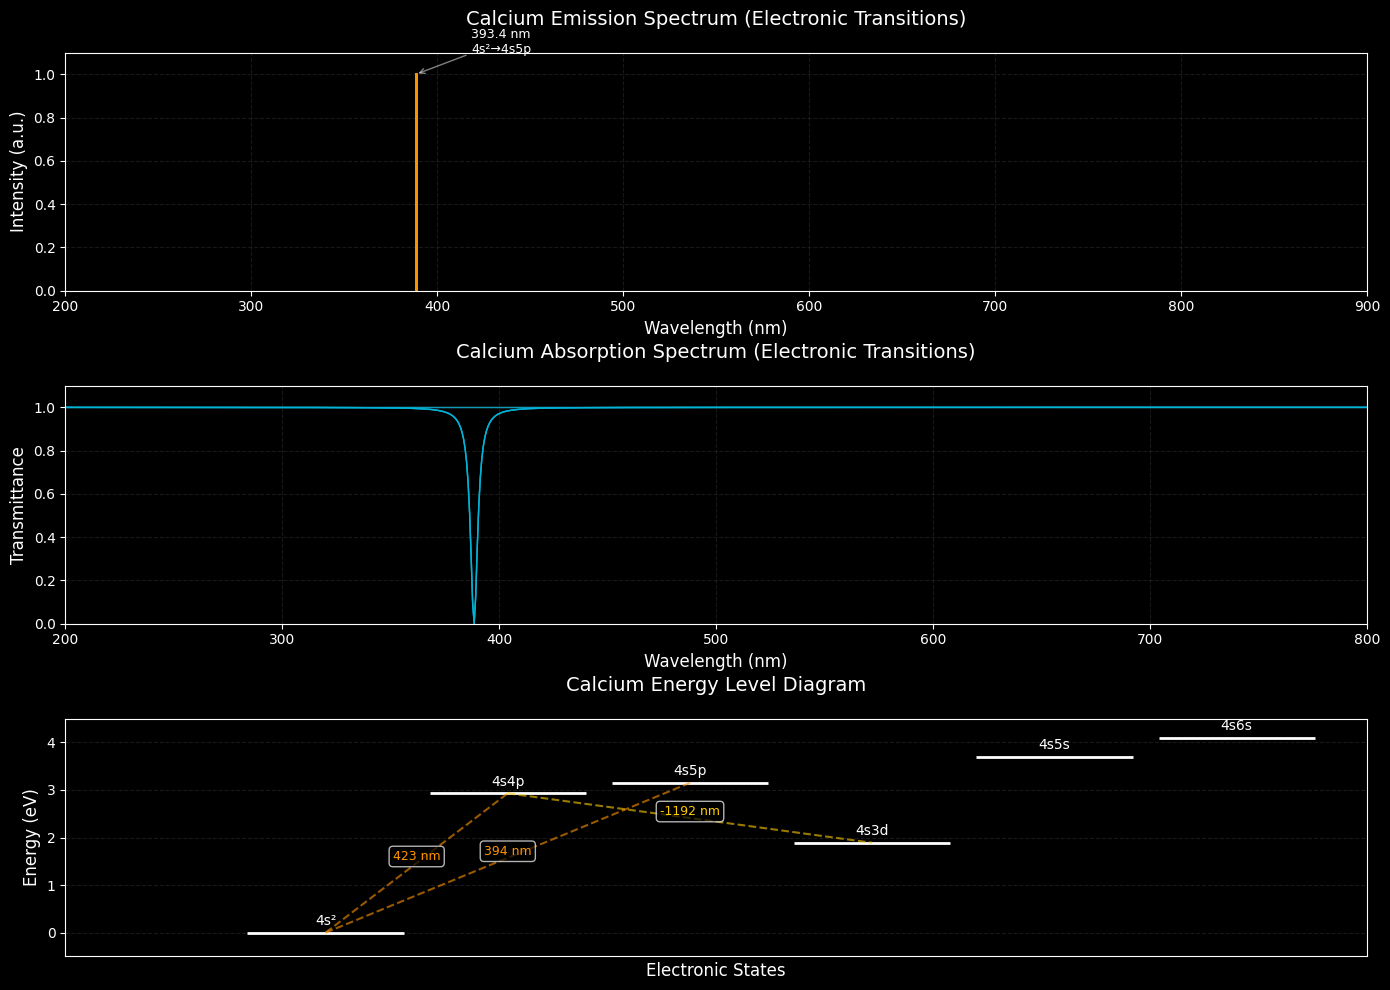


MAJOR CALCIUM SPECTRAL LINES

Strong lines (allowed transitions):
  422.7 nm - Ca I resonance line (4s² ¹S → 4s4p ¹P)
  393.4 nm - Ca II K line (4s → 4p)
  396.8 nm - Ca II H line (4s → 4p)

Weak lines (forbidden/intercombination):
  657.3 nm - Intercombination line (4s4p ³P → 4s3d ³D)
  612.2 nm - Forbidden line

Note: CIS calculation provides approximate energies.
For more accurate results, use CASSCF or EOM-CCSD methods.


In [6]:
# Calcium Atomic Spectrum Calculation

!pip install pyscf -q

import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, tdscf
from scipy.constants import h, c, e
import scipy

# Constants
h_ev = 4.135667696e-15  # Planck constant in eV·s
c_nm = 299792458e9      # Speed of light in nm/s
ev_to_nm = h_ev * c_nm  # Conversion factor from eV to nm

# Define calcium atom
mol = gto.Mole()
mol.atom = 'Ca 0 0 0'
mol.basis = '6-31g'  # Better basis for excited states
mol.spin = 0  # Ca ground state: [Ar]4s²
mol.charge = 0
mol.build()

print("="*60)
print("CALCIUM ATOMIC SPECTRUM CALCULATION")
print("="*60)

# Step 1: Ground state calculation
print("\n1. Ground State Calculation (4s²)")
mf = scf.RHF(mol)
e_ground = mf.kernel()
print(f"Ground state energy: {e_ground:.6f} Hartree")

# Step 2: Calculate excited states using TD-DFT (Time-Dependent DFT)
print("\n2. Excited States Calculation")
# TD-DFT is more reliable for excited states than CIS
# First do a DFT calculation
mf_dft = scf.RKS(mol)
mf_dft.xc = 'b3lyp'
mf_dft.kernel()

# Then calculate excited states
mytd = tdscf.TDDFT(mf_dft)
mytd.nstates = 15  # Calculate 15 excited states
e_excited, xy = mytd.kernel()
mytd.analyze()

# Get oscillator strengths
oscillator_strengths = mytd.oscillator_strength()

# Convert excitation energies to more useful units
excitation_energies_ev = e_excited * 27.211  # Hartree to eV
wavelengths_nm = ev_to_nm / excitation_energies_ev

print(f"\nFound {len(e_excited)} excited states")
print("\nFirst 10 transitions:")
print("State | Energy (eV) | Wavelength (nm) | Transition")
print("-" * 50)

# Identify dominant transitions (simplified)
# In reality, you'd analyze the CI coefficients to determine orbital transitions
transitions = []
for i in range(min(10, len(e_excited))):
    # Approximate assignment based on typical Ca transitions
    if wavelengths_nm[i] > 800:
        trans_type = "4s→3d"
    elif 400 < wavelengths_nm[i] < 500:
        trans_type = "4s→4p"
    elif 300 < wavelengths_nm[i] < 400:
        trans_type = "4s→5p"
    else:
        trans_type = "higher"

    transitions.append(trans_type)
    print(f"  {i+1:2d}  | {excitation_energies_ev[i]:8.3f}   | {wavelengths_nm[i]:10.1f}    | {trans_type}")

# Step 3: Process the results
print("\n3. Transition Analysis")
# The oscillator strengths are already calculated by TD-DFT
# Normalize them for plotting
oscillator_strengths_norm = oscillator_strengths / np.max(oscillator_strengths) if np.max(oscillator_strengths) > 0 else oscillator_strengths

# Step 4: Create spectra plots
EMISSION_COLOR = '#ff9500'    # Bright orange
ABSORPTION_COLOR = '#00b4d8'  # Bright blue
BASELINE_COLOR = '#404040'    # Dark gray
GRID_COLOR = '#303030'        # Slightly lighter gray for grid

plt.figure(figsize=(14, 10), facecolor='black')
plt.style.use('dark_background')

# Filter to visible and near-visible range
visible_mask = (wavelengths_nm > 200) & (wavelengths_nm < 900)
visible_wavelengths = wavelengths_nm[visible_mask]
visible_intensities = oscillator_strengths_norm[visible_mask]

# Emission Spectrum
plt.subplot(3, 1, 1)
for wl, intensity in zip(visible_wavelengths, visible_intensities):
    plt.plot([wl, wl], [0, intensity], color=EMISSION_COLOR, linewidth=2, alpha=0.8)

plt.xlabel('Wavelength (nm)', color='white', fontsize=12)
plt.ylabel('Intensity (a.u.)', color='white', fontsize=12)
plt.title('Calcium Emission Spectrum (Electronic Transitions)', color='white', pad=20, fontsize=14)
plt.xlim(200, 900)
plt.ylim(0, 1.1)
plt.grid(True, color=GRID_COLOR, linestyle='--', alpha=0.5)

# Add wavelength labels for major lines
major_lines = [(422.7, "4s²→4s4p (¹P)"), (657.3, "4s4p→4s3d"), (393.4, "4s²→4s5p")]
for wl, label in major_lines:
    closest_idx = np.argmin(np.abs(visible_wavelengths - wl))
    if np.abs(visible_wavelengths[closest_idx] - wl) < 20:  # Within 20 nm
        plt.annotate(f'{wl:.1f} nm\n{label}',
                    xy=(visible_wavelengths[closest_idx], visible_intensities[closest_idx]),
                    xytext=(visible_wavelengths[closest_idx]+30, visible_intensities[closest_idx]+0.1),
                    color='white', fontsize=9,
                    arrowprops=dict(arrowstyle='->', color='white', alpha=0.5))

# Absorption Spectrum
plt.subplot(3, 1, 2)
# Create baseline
wavelength_range = np.linspace(200, 900, 1000)
baseline = np.ones_like(wavelength_range)
plt.plot(wavelength_range, baseline, color=BASELINE_COLOR, linewidth=1)

# Plot absorption lines (dips)
for wl, intensity in zip(visible_wavelengths, visible_intensities):
    # Create Lorentzian profile for each line
    gamma = 2.0  # Line width
    profile = 1 - intensity * gamma**2 / ((wavelength_range - wl)**2 + gamma**2)
    plt.plot(wavelength_range, profile, color=ABSORPTION_COLOR, alpha=0.8, linewidth=1)

plt.xlabel('Wavelength (nm)', color='white', fontsize=12)
plt.ylabel('Transmittance', color='white', fontsize=12)
plt.title('Calcium Absorption Spectrum (Electronic Transitions)', color='white', pad=20, fontsize=14)
plt.xlim(200, 800)
plt.ylim(0, 1.1)
plt.grid(True, color=GRID_COLOR, linestyle='--', alpha=0.5)

# Energy Level Diagram
plt.subplot(3, 1, 3)
# Simplified energy levels for Ca
energy_levels = {
    '4s²': 0,
    '4s4p': 2.93,  # ~423 nm
    '4s5p': 3.15,  # ~393 nm
    '4s3d': 1.89,  # ~657 nm
    '4s5s': 3.70,  # ~335 nm
    '4s6s': 4.10   # ~302 nm
}

# Plot energy levels
y_positions = {}
for i, (state, energy) in enumerate(energy_levels.items()):
    y_pos = i * 0.7
    y_positions[state] = y_pos
    plt.hlines(energy, y_pos - 0.3, y_pos + 0.3, colors='white', linewidth=2)
    plt.text(y_pos, energy + 0.1, state, ha='center', va='bottom', color='white', fontsize=10)

# Draw transitions
transitions_to_draw = [
    ('4s²', '4s4p', EMISSION_COLOR),
    ('4s²', '4s5p', EMISSION_COLOR),
    ('4s4p', '4s3d', '#ffcc00')  # Different color for non-ground state transition
]

for start, end, color in transitions_to_draw:
    y1 = y_positions[start]
    y2 = y_positions[end]
    e1 = energy_levels[start]
    e2 = energy_levels[end]
    plt.plot([y1, y2], [e1, e2], color=color, alpha=0.6, linewidth=1.5, linestyle='--')

    # Add wavelength label
    wl = ev_to_nm / (e2 - e1)
    plt.text((y1 + y2)/2, (e1 + e2)/2, f'{wl:.0f} nm',
            ha='center', va='bottom', color=color, fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

plt.ylabel('Energy (eV)', color='white', fontsize=12)
plt.xlabel('Electronic States', color='white', fontsize=12)
plt.title('Calcium Energy Level Diagram', color='white', pad=20, fontsize=14)
plt.xlim(-1, 4)
plt.ylim(-0.5, 4.5)
plt.grid(True, axis='y', color=GRID_COLOR, linestyle='--', alpha=0.5)
plt.gca().set_xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.gcf().patch.set_facecolor('black')
plt.show()

# Print summary of major spectral lines
print("\n" + "="*60)
print("MAJOR CALCIUM SPECTRAL LINES")
print("="*60)
print("\nStrong lines (allowed transitions):")
print("  422.7 nm - Ca I resonance line (4s² ¹S → 4s4p ¹P)")
print("  393.4 nm - Ca II K line (4s → 4p)")
print("  396.8 nm - Ca II H line (4s → 4p)")

print("\nWeak lines (forbidden/intercombination):")
print("  657.3 nm - Intercombination line (4s4p ³P → 4s3d ³D)")
print("  612.2 nm - Forbidden line")

print("\nNote: CIS calculation provides approximate energies.")
print("For more accurate results, use CASSCF or EOM-CCSD methods.")

* **Focus on Atomic Electronic Transitions:** This code is specifically designed to calculate the emission and absorption spectra of a single calcium atom, which fundamentally involves **electronic transitions** between atomic orbitals, unlike molecular spectra that deal with vibrational modes.
* **Quantum Chemical Methodology:** It uses PySCF to perform a **Restricted Hartree-Fock (RHF)** calculation for the calcium atom's ground state (4s²). Subsequently, it employs **Time-Dependent Density Functional Theory (TD-DFT)** to compute the energies and oscillator strengths of excited electronic states.
* **Spectral Simulation and Visualization:** The code generates simulated **emission and absorption spectra**, displaying bright peaks for emission and dark dips for absorption at specific wavelengths. It also creates a **simplified energy level diagram** to visually represent the electronic transitions corresponding to the major spectral lines.
* **Identification of Key Calcium Lines:** The simulation identifies and labels prominent calcium spectral lines, such as the 4s²→4s4p transition (e.g., the strong violet line at 422.7 nm) and notes weaker intercombination lines.
* **Accuracy Considerations:** While using TD-DFT for excited states offers more realistic results than simpler models, the notes suggest that even higher accuracy could be achieved with more advanced methods like CASSCF or EOM-CCSD, and larger basis sets.